<a href="https://colab.research.google.com/github/sangjin94/itwill-python/blob/main/ml11_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Learning(앙상블 학습 방법)

* 앙상블(ensemble) : 머신 러닝에서 사용되는 일련의 모델(알고리즘) 들.
  * 서로 다른 모델 여러 개를 학습시키는 방법.
  * 한 가지 모델을 서로 다른 훈련 셋에서 학습시키는 방법. 
* 앙상블 학습 방법: 앙상블을 사용한 머신 러닝 방법
  * 투표(voting) 방식: 여러 모델을 학습 시켜서 각각의 예측값을 투표(다수결) 또는 평균값으로 예측하는 방법. 
  * **Bagging(Bootstrap Aggregaging)**: 중복을 허용해서 샘플링한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측
  * pasting: 중복을 허용하지 않고 샘플링한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측하는 방법.
  * **Random Forest**: **Bagging**을 사용한 **Decision Tree**들의 **Ensemble** 학습 방법.

#Imports

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC,SVR # Support Vector Machine을 사용한 분류 알고리즘
from sklearn.ensemble import VotingClassifier,BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier

from xgboost import XGBClassifier # Extreme Gradient Boosting
from lightgbm import LGBMClassifier 

# Dataset 준비

2개의 특성(x1,x2)과, 2개의 클래스(0,1)를 갖는 가상의 데이터 셋

In [58]:
X,y= datasets.make_moons(n_samples=500,noise=0.3,random_state=42)

In [59]:
X.shape,y.shape

((500, 2), (500,))

In [60]:
 np.unique(y)

array([0, 1])

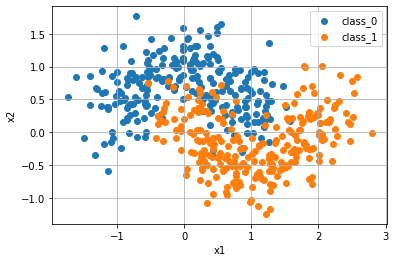

In [61]:
plt.scatter(X[y==0,0],X[y==0,1],label='class_0')
plt.scatter(X[y==1,0],X[y==1,1],label='class_1')
plt.legend()
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [62]:
# train/test set 분리
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# 머신 러닝 모델 비교

* 여러 개의 머신 러닝 모델들을 훈련셋(X_train,X_test)로 훈련
  * KNN, Logistic Regression, SGD, Decision Tree, SVM
* 훈련 된 각 모델에서 테스트 셋의 점수(정확도)를 계산, 평가 

In [63]:
# 5개의 머신 러닝 학습기 객체 생성
knn_clf= KNeighborsClassifier(n_jobs=-1)
log_clf=LogisticRegression(random_state=42,n_jobs=-1)
sgd_clf=SGDClassifier(loss='log',n_jobs=-1,random_state=42)
tree_clf=DecisionTreeClassifier(random_state=42)
svm_clf=SVC(probability=True,random_state=42)

In [64]:
knn_clf.__class__

sklearn.neighbors._classification.KNeighborsClassifier

In [65]:
classifiers=[knn_clf,log_clf,sgd_clf,tree_clf,svm_clf]
for clf in classifiers:
  clf.fit(X_train,y_train) # 모델 훈련
  acc= clf.score(X_test,y_test) # 테스트 셋 평가 점수(정확도) 계산
  print(clf.__class__.__name__,'accuracy:',acc)

KNeighborsClassifier accuracy:  0.93
LogisticRegression accuracy:  0.81
SGDClassifier accuracy:  0.81
DecisionTreeClassifier accuracy:  0.84
SVC accuracy:  0.93


# Voting Ensemble

In [66]:
# VotingEnsemble 학습기 객체 생성
vote_clf=VotingClassifier(estimators=[('knn',knn_clf),
                                      ('log',log_clf),
                                      ('sgd',sgd_clf),
                                      ('tree',tree_clf),
                                      ('svm',svm_clf)],
                          voting='soft',n_jobs=-1)
# estimators:VotingEnsemble을 만들기 위한 ML모델 ('모델이름', 모델 객체) 튜플들의 리스트
# voting: 투표방식
#> voting='hard': 모든 ML모델들이 동일하게 1표씩 행사.
#> voting='soft': 각 모델에 예측값에 각 모델에서 예측된 예측 확률을 가중치로 곱합 값을 사용해서 결과를 예측
#> 일반적으로 soft voting 방식이 hard voting 방식보다 성능이 더 좋다고 알려져 있음.  

In [69]:
# 모델 학습
vote_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('log',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto', n_jobs=-1,
                                                 penalty='l2', random_s...
                                     

In [ ]:
# 모델 평가
vote_clf.score(X_test, y_test)

# Bagging(Bootstrap Aggregating) Ensemble

In [70]:
# bagging ensemble 객체 생성 
bagging_clf=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                              n_estimators=50,
                              max_samples=100,
                              bootstrap=True,
                              oob_score=True,
                              n_jobs=-1,
                              random_state=42)

BaggingClassifier의 파라미터: 

* base_estimator: 기본 추정기(예측기). 머신 러닝 모델 객체.
* n_estimators: 추정기(예측기)의 개수. 기본값 10.
* max_samples: 훈련 셋의 부분 집합이 가질 수 있는 최대 샘플 개수(정수) 또는 비율(0~1.0). 기본값은 1.0.
* bootstrap: True(중복 허용 샘플링). False(중복 불허 샘플링,pasting). 기본값은 True. 
* oob_score: True(OOB 샘플로 평가 점수 계산). False(OOB 샘플로 평가 점수를 계산 하지않음). 기본값은 False.
  * OOB(Out of Bagging) 샘플: 중복 허용 샘플링을 하는 동안 한 번도 샘플링 되지못하고 남아 있는 훈련 셋의 샘플.
  * OOB sample은 validation set 역할을 할 수 있음.

In [71]:
# 모델 훈련
bagging_clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
  

In [72]:
bagging_clf.oob_score_ # OOB(Out-of-Bagging) 샘플에서의 점수(정확도) --> 보통 테스트 셋의 점수와 비슷함.

0.905

In [73]:
bagging_clf.score(X_test, y_test)

0.91

# RandomForest 

Decision Tree를 사용하는 Bagging Ensemble 학습 방법.

* DecisionTree의 파라미터와 Bagging의 파라미터들을 갖음. 
* GridSearchCV,RandomizedSearchCV을 이용해서 tree와 bagging의 하이퍼파라미터들을 튜닝할 수 있음.


In [80]:
# Random Forest 분류기 객체 생성
forest_clf=RandomForestClassifier(n_estimators=50,max_samples=100,oob_score=True,n_jobs=-1,random_state=42)

In [81]:
# 모델 훈련
forest_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [83]:
#OOB 샘플의 점수
forest_clf.oob_score_

0.9125

In [84]:
# 테스트 셋의 정확도
forest_clf.score(X_test,y_test)

0.91

# Wine datasets

red/white wine 분류

In [86]:
wine=pd.read_csv('https://bit.ly/wine-date')

In [87]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [90]:
# feature matrix, target vector
X=wine.drop(columns='class').values
y=wine['class'].values
X.shape,y.shape

((6497, 3), (6497,))

In [92]:
# train/test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               stratify=y,
                                               random_state=42)

In [93]:
# Random Forest 모델 생성
forest_clf=RandomForestClassifier(oob_score=True,n_jobs=-1,random_state=42)

In [94]:
# 모델 훈련
forest_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [95]:
# 훈련 셋에서의 정확도 - Overfitting 여부를 확인하기 위해서
forest_clf.score(X_train,y_train)

0.9978833942659227

In [97]:
# OOB 샘플 점수
forest_clf.oob_score_

0.8964787377333077

In [98]:
# 테스트 셋에서의 정확도
forest_clf.score(X_test,y_test)

0.8892307692307693

In [99]:
cross_validate(estimator=forest_clf,X=X_train,y=y_train,n_jobs=-1,return_train_score=True)

{'fit_time': array([0.80554056, 0.80799937, 0.68955112, 0.67567086, 0.55514336]),
 'score_time': array([0.10267138, 0.10267854, 0.10712361, 0.10246253, 0.10220051]),
 'test_score': array([0.90480769, 0.89903846, 0.88546679, 0.89412897, 0.88546679]),
 'train_score': array([0.99807554, 0.99807554, 0.9983165 , 0.998076  , 0.9983165 ])}

# Extra Tree

* Random Forest 와 비슷한 점:
  * 여러 개(기본값은 100개)의 decision tree 들을 훈련 
  * decision tree의 파라미터들을 튜닝할 수 있음. 
* Random Forest와 다른 점: 
  * Bootstrap 샘플을 사용하지 않음. 여러 개의 dcision tree들을 전체 훈련 셋을 사용해서 훈련. 
  * 노드를 분할할 때 가장 좋은 분할을 찾는 게 아니라, 무작위 분할을 사용. 
    * Random Forest는 최적의 분할을 찾기 위해서 많은 훈련 시간이 필요. 
    * Extra Tree는 무작위 분할을 하기 때문에 훈련 시간이 빠름.

In [100]:
extra_tree=ExtraTreesClassifier(n_jobs=-1,random_state=42)
cv=cross_validate(estimator=extra_tree,X=X_train,y=y_train,n_jobs=-1,return_train_score=True)
cv

{'fit_time': array([0.57440805, 0.57387137, 0.47079134, 0.47296309, 0.36563921]),
 'score_time': array([0.10237813, 0.10396051, 0.10266042, 0.10587215, 0.1028142 ]),
 'test_score': array([0.89519231, 0.90480769, 0.88450433, 0.89509143, 0.8825794 ]),
 'train_score': array([0.99807554, 0.99807554, 0.9983165 , 0.998076  , 0.9983165 ])}

In [101]:
np.mean(cv['train_score'])

0.9981720130385032

In [102]:
np.mean(cv['test_score'])
#> overfitting이 큼. 

0.8924350336862368

In [103]:
# 검증 셋(validation set)에서의 평가 점수만 리턴 - overfitting 여부는 확인 할 수 없음.
cross_val_score(estimator=extra_tree,X=X_train,y=y_train,n_jobs=-1)

array([0.89519231, 0.90480769, 0.88450433, 0.89509143, 0.8825794 ])

# Gradient Boosting 

* 깊이(depth)가 얕은 decision tree들을 직렬(순차적으로) 연결해서 훈련.
* 훈련시킬 때, 이전 훈련 단계에서 발생한 오차들을 그 다음 훈련에서 가중치를 주고 훈련시킴. 
* 장점: 깊이가 얕은 tree를 사용하기 때문에. 과대적합이 작아지고, 높은 일반화 성능을 기대할 수 있음. 
* 이미지에 강함.
* 단점: Random Forest 처럼 병렬로 훈련시킬 수 없음(n_jobs 파라미터가 없음). 훈련속도가 느려짐 .
* Gradient Descent(경사 하강법) + Decision Tree + Ensemble 파라미터들을 튜닝할 수 있음. 

In [104]:
# 모델 생성
grad_boost= GradientBoostingClassifier(random_state=42)

In [107]:
cv=cross_validate(estimator=grad_boost,X=X_train,y=y_train,n_jobs=-1,return_train_score=True)
cv

{'fit_time': array([0.49342275, 0.4775393 , 0.49726462, 0.49328804, 0.32196021]),
 'score_time': array([0.00488544, 0.00377417, 0.00384474, 0.0036056 , 0.00288272]),
 'test_score': array([0.87692308, 0.87692308, 0.86717998, 0.87680462, 0.85948027]),
 'train_score': array([0.88501323, 0.88645658, 0.89009139, 0.88287638, 0.88624339])}

In [108]:
np.mean(cv['train_score'])

0.886136193834053

In [109]:
np.mean(cv['test_score'])
#> overfitting이 거의 없음.

0.8714622047827053